In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from jupyterthemes import jtplot
from IPython.core.debugger import Tracer
jtplot.style()

/Users/arunesh/Code/miniconda3/envs/mml_env_local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#CLI args [data_set_idx, z_dim, time_steps]
#Example: python vrae  data_set_idx=0 z_dim=20 time_steps=50

# X \in {0,1}^{batch_size, dim_x, time_steps}

#############################
# Constant params
#############################
x_in_dim = 88

# Params replicated from Fabius et. al Paper
beta_1 = 0.05
beta_2 = 0.001
num_epochs = 10#40000 #TEST
learning_rate_1 = 2e-5
learning_rate_2 = 1e-5
num_epochs_to_diff_learn_rate = 5#16000 #TEST 
num_epochs_to_save_model = 4#1000 #TEST
num_hidden_units = 500
#decay_rate = .7

##############################
# Hyperparams
##############################
data_set_idx = 0
z_dim = 20
time_steps = 50 
batch_size = 100
epoch_to_load = 8 # If greater than 0 load model from that epoch
run_to_load = 1

# Dir paths
data_sets = ['Nottingham','JSB Chorales']
load_root = '../MIDI_Data_PianoRolls/'
log_root =  '../logs/MIDI_Data_PianoRolls'

train_dir_path = os.path.join(load_root,data_sets[data_set_idx],'train')
valid_dir_path = os.path.join(load_root,data_sets[data_set_idx],'valid')
test_dir_path = os.path.join(load_root,data_sets[data_set_idx],'test')

In [3]:
#############################
# Helper functions
#############################
def clip_roll(piano_roll, time_steps=50):
    samples = []
    num_samples = int(piano_roll.shape[1] / time_steps)
    for i in range(num_samples):
        start_idx = time_steps*i
        end_idx = (time_steps*(i+1))
        samples.append(piano_roll[:,start_idx:end_idx])
    return samples   

def create_samples(load_root, time_steps=50, verbose=False):
    if not os.path.isdir(load_root):
        print("Invalid load_root directory.")
        sys.exit(0)
        
    samples = []
    for (dirpath, dirnames, filenames) in os.walk(load_root):
        for file in filenames:
            if file.endswith('.npy'):
                load_filepath = os.path.join(dirpath,file)
                if verbose:
                    print(load_filepath)
                piano_roll = np.load(load_filepath).T
                samples = samples + clip_roll(piano_roll,time_steps=time_steps)

    return np.stack(samples)

def feed_dict(batch_size, samples_type=None):
    if samples_type == 'train':
        indeces = np.random.randint(num_train_samples, size=batch_size)
        samples = train_samples
        
    elif samples_type == 'valid':
        indeces = np.random.randint(num_valid_samples, size=batch_size)
        samples = valid_samples
        
    elif samples_type == 'test':
        indeces = np.random.randint(num_test_samples, size=batch_size)
        samples = test_samples
        
    return np.take(samples, indeces, axis=0)

In [4]:
#############################
# Setup Load/Save paths
#############################

train_samples = create_samples(train_dir_path, time_steps=time_steps, verbose=False)
valid_samples = create_samples(valid_dir_path, time_steps=time_steps, verbose=False)
test_samples = create_samples(test_dir_path, time_steps=time_steps, verbose=False)

num_train_samples = train_samples.shape[0] 
num_valid_samples = valid_samples.shape[0] 
num_test_samples = test_samples.shape[0] 


network_params =  ''.join([
                  'time_steps={}-'.format(time_steps),          
                  'latent_dim={}-'.format(z_dim),          
                  'dataset={}'.format(data_sets[data_set_idx])])

# Dir structure : /base_dir/network_params/run_xx/train_or_test/
log_base_dir = os.path.join(log_root, network_params)

# Check for previous runs
if not os.path.isdir(log_base_dir):
    os.makedirs(log_base_dir)

previous_runs = os.listdir(log_base_dir)

if len(previous_runs) == 0:
    run_number = 1
else:
    run_number = max([int(str.split(s,'run_')[1]) for s in previous_runs if 'run' in s]) + 1

if epoch_to_load > 0:
    run_number = run_to_load

log_dir = os.path.join(log_base_dir,'run_{0:02d}'.format(run_number))

train_summary_writer = tf.summary.FileWriter(log_dir + '/train')
valid_summary_writer = tf.summary.FileWriter(log_dir + '/valid')
test_summary_writer = tf.summary.FileWriter(log_dir + '/test')
model_save_path = log_dir + '/models'

In [5]:
#############################
# Setup graph
#############################
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(batch_size, x_in_dim, time_steps))

# time_slices containts input x at time t across batches.
x_in = time_steps * [None]
x_out = time_steps * [None]
h_enc = time_steps * [None]
h_dec = (time_steps + 1) * [None]

for t in range(time_steps):
    x_in[t] = tf.squeeze(tf.slice(X,begin=[0,0,t],size=[-1,-1,1]),axis=2)

###### Encoder network ###########
with tf.variable_scope('encoder_rnn'):
    cell_enc = tf.nn.rnn_cell.BasicRNNCell(num_hidden_units,activation=tf.nn.tanh)
    h_enc[0] = tf.zeros([batch_size,num_hidden_units], dtype=tf.float32) # Initial state is 0

    # h_t+1 = tanh(Wenc*h_t + Win*x_t+1 + b )
    #Most basic RNN: output = new_state = act(W * input + U * state + B).
    #https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/python/ops/rnn_cell_impl.py
    for t in range(time_steps-1):
        _ , h_enc[t+1] = cell_enc(inputs=x_in[t+1], state=h_enc[t])


mu_enc = tf.layers.dense(h_enc[-1], z_dim, activation=None, name='mu_enc')
log_sigma_enc = tf.layers.dense(h_enc[-1], z_dim, activation=None, name='log_sigma_enc')

###### Reparametrize ##############
eps = tf.random_normal(tf.shape(log_sigma_enc))
z = mu_enc + tf.exp(log_sigma_enc) * eps

##### Decoder network ############
with tf.variable_scope('decoder_rnn'):
    W_out = tf.get_variable('W_out',shape=[num_hidden_units, x_in_dim])
    b_out = tf.get_variable('b_out',shape=[x_in_dim])
    
    cell_dec = tf.nn.rnn_cell.BasicRNNCell(num_hidden_units,activation=tf.nn.tanh)
    h_dec[0] = tf.layers.dense(z, num_hidden_units, activation=tf.nn.tanh)
    
    for t in range(time_steps):
        x_out[t] = tf.nn.sigmoid(tf.matmul(h_dec[t], W_out) + b_out)
        if t < time_steps - 1:
            _, h_dec[t+1] = cell_dec(inputs=x_out[t], state=h_dec[t])

##### Loss #####################
with tf.variable_scope('loss'):
    
    
    # Latent loss: -KL[q(z|x)|p(z)]
    with tf.variable_scope('latent_loss'):
        sigma_sq_enc = tf.square(tf.exp(log_sigma_enc))
        latent_loss = -.5 * tf.reduce_mean(tf.reduce_sum((1 + tf.log(1e-10 + sigma_sq_enc)) - tf.square(mu_enc) - sigma_sq_enc, axis=1),axis=0)
        latent_loss_summ = tf.summary.scalar('latent_loss',latent_loss)
        
    # Reconstruction Loss: log(p(x|z))    
    with tf.variable_scope('recon_loss'):    
        for i in range(time_steps):
            if i == 0:
                recon_loss_ = x_in[i] * tf.log(1e-10 + x_out[i]) + (1 - x_in[i]) * tf.log(1e-10+1-x_out[i])
            else:
                recon_loss_ += x_in[i] * tf.log(1e-10 + x_out[i]) + (1 - x_in[i]) * tf.log(1e-10+1-x_out[i])
            
        #collapse the loss, mean across a sample across all x_dim and time points, mean over batches
        recon_loss = -tf.reduce_mean(tf.reduce_mean(recon_loss_/(time_steps),axis=1),axis=0)

            
    recon_loss_summ = tf.summary.scalar('recon_loss', recon_loss)
                
    with tf.variable_scope('total_loss'):
        total_loss = latent_loss + recon_loss
    
    total_loss_summ = tf.summary.scalar('total_loss', total_loss)

global_step = tf.Variable(0,name='global_step') 

#learning_rate = tf.train.exponential_decay(initial_learning_rate, epoch_num, num_epochs, decay_rate, staircase=False)
learning_rate = tf.Variable(learning_rate_1,name='learning_rate')
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta_1, beta2=beta_2).minimize(total_loss,global_step=global_step)    
scalar_summaries = tf.summary.merge([latent_loss_summ, recon_loss_summ, total_loss_summ])
#image_summaries = tf.summary.merge()

train_summary_writer.add_graph(tf.get_default_graph())

In [8]:
#############################
# Training/Logging
#############################
num_batches = int(num_train_samples/batch_size)
global_step_op = tf.train.get_global_step()
saver = tf.train.Saver()

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    
    # Epoch_to_load has sentinel value of -1 for train mode. else it specifies the epoch to load.
    if epoch_to_load >= 0:
        
        saver.restore(sess, model_save_path + '/epoch_{}.ckpt'.format(epoch_to_load))
        
        loss, x_out_, x_in_, learning_rate_, latent_loss_ = \
                sess.run([total_loss, x_out, x_in, learning_rate, latent_loss],feed_dict={X: feed_dict(batch_size,'train')})
    else:
        sess.run(tf.global_variables_initializer())
        for epoch in range(num_epochs):
            epoch_loss = 0.
            epoch_latent_loss = 0.
            for batch in range(num_batches):
                batch_num = sess.run(global_step_op)
                
                if epoch < num_epochs_to_diff_learn_rate:
                    curr_learning_rate = learning_rate_1
                else:
                    curr_learning_rate = learning_rate_2
                
                #_ , loss, scalar_train_summaries, x_out_, x_in_,learning_rate_,latent_loss_ = \
                #sess.run([train_step, total_loss, scalar_summaries, x_out, x_in,learning_rate, latent_loss],feed_dict={X: feed_dict(batch_size,'train'), learning_rate: curr_learning_rate})
                
                _ , loss, scalar_train_summaries, learning_rate_, latent_loss_ = \
                sess.run([train_step, total_loss, scalar_summaries, learning_rate, latent_loss],feed_dict={X: feed_dict(batch_size,'train'), learning_rate: curr_learning_rate})
                
                # Check for NaN
                if np.isnan(loss):
                    sys.exit("Loss during training at epoch: {}".format(epoch))
                
                epoch_loss += loss
                epoch_latent_loss += latent_loss_
                
            print('Average loss epoch {0}: {1}'.format(epoch, epoch_loss/num_batches)) 
            print('Average latent loss epoch {0}: {1}'.format(epoch, epoch_latent_loss/num_batches)) 
            print('Learning Rate {}'.format(learning_rate_))
            
            # Write train summaries once a epoch
            scalar_train_summaries = sess.run(scalar_summaries,feed_dict={X: feed_dict(batch_size,'train')})
            train_summary_writer.add_summary(scalar_train_summaries, global_step=batch_num)
            
            # Write validation summaries
            scalar_valid_summaries = sess.run(scalar_summaries,feed_dict={X: feed_dict(batch_size,'valid')})
            valid_summary_writer.add_summary(scalar_valid_summaries, global_step=batch_num)
            
            # Write test summaries
            scalar_test_summaries = sess.run(scalar_summaries,feed_dict={X: feed_dict(batch_size,'test')})
            test_summary_writer.add_summary(scalar_test_summaries, global_step=batch_num)
            
            # Save the models
            if epoch % num_epochs_to_save_model == 0:
                save_path = saver.save(sess, model_save_path + '/epoch_{}.ckpt'.format(epoch))
        

INFO:tensorflow:Restoring parameters from ../logs/MIDI_Data_PianoRolls/time_steps=50-latent_dim=20-dataset=Nottingham/run_01/models/epoch_8.ckpt
0.195257


In [9]:
def plot_x_io(x, samp_num):
    x_arr = np.asarray(x)
    plt.imshow(x_arr[:,samp_num,:].T)
    plt.show()

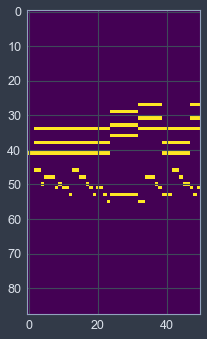

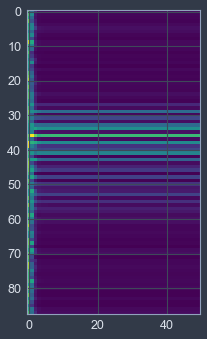

In [10]:
plot_x_io(x_in_, 0)
plot_x_io(x_out_, 0)
